# Settings

In [1]:
NB_FEATURES = 14
NB_VALUES = 3
NB_TESTS_PER_SETTINGS = 10
MAX_RULES = 10000
STEP_SIZE = 100
RULES_CONDITIONS = 1.0
BRUTEFORCE = False

DEBUG = False

MAX_LOOP = 1000000

SEED = 42

if DEBUG:
    NB_FEATURES = 5
    NB_VALUES = 3 
    NB_TESTS_PER_SETTINGS = 10
    MAX_RULES = 100
    STEP_SIZE = 10

In [2]:
from pylfit.postprocessing import compute_counterfactuals, bruteforce_counterfactuals
from pylfit.objects import LegacyAtom, Rule
from pylfit.models import DMVLP
from pylfit.datasets import DiscreteStateTransitionsDataset

import random
import time
import pandas
import seaborn as sns
from matplotlib import colors as mcolors

import matplotlib.pyplot as plt

from itertools import chain, combinations

random.seed(SEED)

In [3]:
def random_rule(head, features, max_body_size):
    body = {}
    nb_conditions = random.randint(1,max_body_size)
    while len(body) < nb_conditions:
        var_id = random.randint(0, len(features)-1)
        val = random.choice(features[var_id][1])
        atom = LegacyAtom(variable=features[var_id][0], domain=set(features[var_id][1]), value=val, state_position=var_id)
        valid = True
        for var in body:
            if body[var].state_position == atom.state_position:
                valid = False
                break
        if valid:
            body[atom.variable] = atom
        
    r = Rule(head,body)

    return r

def random_rule_that_matches(feature_state, head, features, max_body_size):
    body = {}
    nb_conditions = random.randint(1,max_body_size)
    while len(body) < nb_conditions:
        var_id = random.randint(0, len(feature_state)-1)
        atom = LegacyAtom(variable=features[var_id][0], domain=set(features[var_id][1]), value=feature_state[var_id], state_position=var_id)
        valid = True
        for var in body:
            if body[var].state_position == atom.state_position:
                valid = False
                break
        if valid:
            body[atom.variable] = atom
        
    r = Rule(head,body)

    return r


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# Compute counterfactual with proposal

In [4]:
# Generate a DMVLP of X rules
features = [("x"+str(i), ["val_"+str(val) for val in range(0,NB_VALUES)]) for i in range(NB_FEATURES)]
targets = [("y", ["val_"+str(val) for val in range(0,NB_VALUES)])]
rules = []

model = DMVLP(features=features, targets=targets)
model.compile()
model.summary()

features_states = model.feature_states()
print("Features states:", len(features_states))

target = targets[0][0]
target_domain = targets[0][1]
print("target:", target, target_domain)

DMVLP summary:
 Algorithm: gula
 Features: 
  x0: ['val_0', 'val_1', 'val_2']
  x1: ['val_0', 'val_1', 'val_2']
  x2: ['val_0', 'val_1', 'val_2']
  x3: ['val_0', 'val_1', 'val_2']
  x4: ['val_0', 'val_1', 'val_2']
  x5: ['val_0', 'val_1', 'val_2']
  x6: ['val_0', 'val_1', 'val_2']
  x7: ['val_0', 'val_1', 'val_2']
  x8: ['val_0', 'val_1', 'val_2']
  x9: ['val_0', 'val_1', 'val_2']
  x10: ['val_0', 'val_1', 'val_2']
  x11: ['val_0', 'val_1', 'val_2']
  x12: ['val_0', 'val_1', 'val_2']
  x13: ['val_0', 'val_1', 'val_2']
 Targets: 
  y: ['val_0', 'val_1', 'val_2']
 Rules: []
Features states: 4782969
target: y ['val_0', 'val_1', 'val_2']


In [5]:
data = []
nb_rules = 10
nb_power = 1
while nb_rules < MAX_RULES:
    nb_rules = 10**nb_power
    nb_power += 1
    print("Rules:",str(nb_rules)+"/"+str(MAX_RULES))
    for test in range(NB_TESTS_PER_SETTINGS):
        print("\rTest:", str(test+1)+"/"+str(NB_TESTS_PER_SETTINGS),end='')
        
        # Generate the counterfactual problem first
        s = random.choice(features_states)
        val_out = random.choice(target_domain)
        val_in = val_out
        while(val_in == val_out):
            val_in = random.choice(target_domain)

        #print("s:", s)
        #print("Val_out:", val_out)
        #print("Val_in:", val_in)
        
        # Create rules for each target value so that the problem is valid
        rules = []
        for val in target_domain:
            val_rules = []
            head = LegacyAtom(variable=target, domain=set(target_domain), value=val, state_position=0)

            loops = 0
            while(len(val_rules) < nb_rules and loops < MAX_LOOP):
                loops += 1
                
                if val == val_out: # s must be matched
                    rule = random_rule_that_matches(s, head, features, int(len(features)*RULES_CONDITIONS))
                else:
                    rule = random_rule(head, features, int(len(features)*RULES_CONDITIONS))

                #print(rule)

                if val == val_in: # s should not match
                    if rule.matches(s):
                        #print("OUT: matches",s)
                        continue

                # Rule must be minimal
                valid = True
                if rule in val_rules:
                    #print("OUT: already in rules")
                    valid = False

                #for r in val_rules:
                #    if r.subsumes(rule) or rule.subsumes(r):
                #        valid = False
                #        break

                if not valid:
                    continue
                
                val_rules.append(rule)

            if loops >= MAX_LOOP:
                print("ERROR, MAX_LOOP reached, cannot find rule valid")
                print("Rules found:", len(val_rules))
            
            rules += val_rules

            #print("Created rules for",str(val),len(val_rules))

        # Minimize the dmvlp

        model = DMVLP(features, targets, rules)
        model.compile()
        #model.summary()

        if BRUTEFORCE:
            begin = time.time()
            solutions = bruteforce_counterfactuals(model, s, target, [val_out], [val_in])[val_in]
            run_time = time.time() - begin
            data.append(["Naïve enumeration", len(model.features), nb_rules, s, val_out, val_in, solutions, len(solutions), run_time])

        begin = time.time()
        solutions = compute_counterfactuals(model, s, target, [val_out], [val_in])[val_in]
        run_time = time.time() - begin
        data.append(["CELOS", len(model.features), nb_rules, s, val_out, val_in, solutions, len(solutions), run_time])
        
        #for i in solutions:
        #    print(i)

    print()
    
df = pandas.DataFrame(data, columns=["method", "features", "rules", "feature_state", "val_out", "val_in", "solutions", "nb_solutions", "run_time"])
display(df)

Rules: 10/10000
Test: 10/10
Rules: 100/10000
Test: 10/10
Rules: 1000/10000
Test: 10/10
Rules: 10000/10000
Test: 10/10


,method,features,rules,feature_state,val_out,val_in,solutions,nb_solutions,run_time
0,CELOS,14,10,"[val_0, val_1, val_2, val_0, val_2, val_1, val...",val_0,val_2,"[{x9(val_1), x6(val_2), x5(val_2), x11(val_0),...",32,0.008991
1,CELOS,14,10,"[val_2, val_1, val_1, val_0, val_0, val_0, val...",val_2,val_1,"[{x13(val_2), x4(val_1), x11(val_2), x5(val_1)...",314,0.226242
2,CELOS,14,10,"[val_2, val_0, val_0, val_2, val_0, val_2, val...",val_1,val_0,"[{x3(val_1), x11(val_2), x13(val_1), x8(val_0)...",307,0.059672
3,CELOS,14,10,"[val_1, val_0, val_2, val_2, val_2, val_1, val...",val_2,val_0,"[{x0(val_0), x7(val_2), x6(val_2), x11(val_0)}...",206,0.128613
4,CELOS,14,10,"[val_0, val_1, val_0, val_1, val_1, val_1, val...",val_1,val_2,"[{x5(val_2), x7(val_1), x1(val_2)}, {x9(val_0)...",45,0.086265
5,CELOS,14,10,"[val_2, val_1, val_1, val_2, val_1, val_2, val...",val_2,val_1,"[{x8(val_2), x13(val_1), x10(val_1)}, {x13(val...",25,0.095914
6,CELOS,14,10,"[val_2, val_2, val_2, val_2, val_1, val_0, val...",val_1,val_2,"[{x13(val_1), x8(val_0), x2(val_0)}, {x13(val_...",48,0.046268
7,CELOS,14,10,"[val_1, val_1, val_1, val_2, val_1, val_1, val...",val_0,val_1,"[{x2(val_2), x11(val_0), x10(val_1)}, {x10(val...",184,0.031961
8,CELOS,14,10,"[val_2, val_1, val_0, val_1, val_2, val_1, val...",val_1,val_0,"[{x1(val_0), x12(val_2), x2(val_1), x10(val_1)...",45,0.029189
9,CELOS,14,10,"[val_0, val_0, val_1, val_1, val_2, val_0, val...",val_2,val_0,"[{x11(val_2), x3(val_2), x8(val_0), x0(val_1),...",341,0.537067


In [6]:
df[df["nb_solutions"]>0]

df.to_csv("results_random_rules.csv")

# Visualize performance

In [7]:
BRUTE_FORCE_COLOR = mcolors.to_rgba("#C6110B") #"lightcoral"
GULA_COLOR = mcolors.to_rgba("#0B7FF3") #"skyblue"
WHIS_VALUE = 10000000

C:\Users\Tony\AppData\Local\Temp\ipykernel_27452\2662625745.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="rules", y="nb_solutions", data=df,


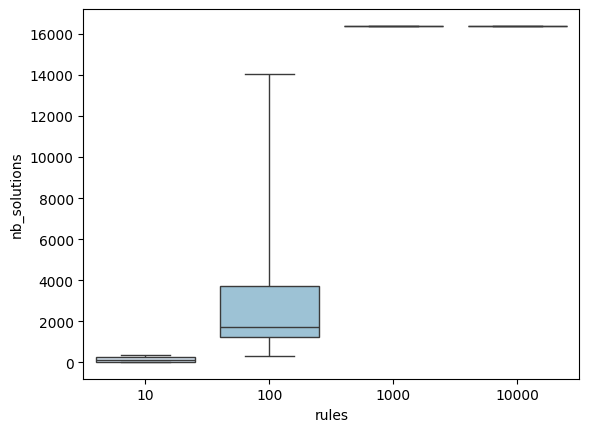

In [8]:
#df_brute_force = df_semantics[df_semantics["method"] == "brute_force"]
ax = sns.boxplot(x="rules", y="nb_solutions", data=df,
                #whiskerprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                #capprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                whis=WHIS_VALUE,
                palette="Blues",
                log_scale=False)

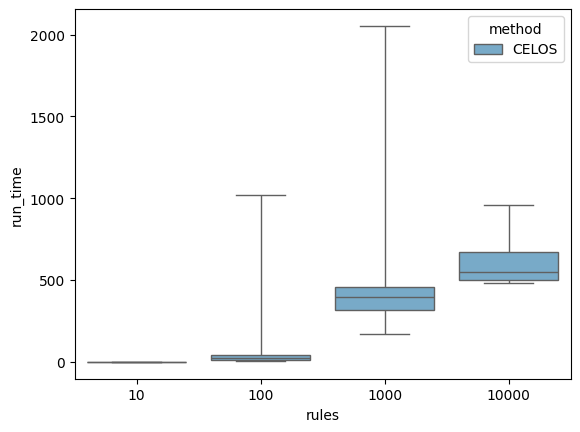

In [9]:
#df_brute_force = df_semantics[df_semantics["method"] == "brute_force"]
ax = sns.boxplot(x="rules", y="run_time", hue="method", data=df,
                #whiskerprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                #capprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                whis=WHIS_VALUE,
                palette="Blues",
                log_scale=False)

#plt.savefig("random_rules_run_times.pdf", bbox_inches='tight')

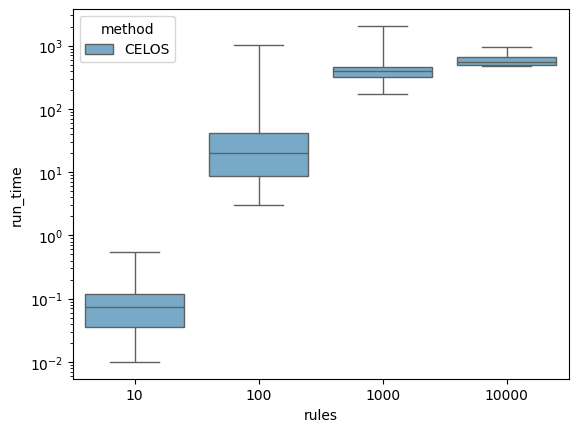

In [10]:
df_tmp = df.copy()
df_tmp["run_time"] += 0.001
ax = sns.boxplot(x="rules", y="run_time", hue="method", data=df_tmp,
                #whiskerprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                #capprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                whis=WHIS_VALUE,
                palette="Blues",
                log_scale=True)

plt.savefig("random_run_times.pdf", bbox_inches='tight')

# DEBUG